In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sqlalchemy import create_engine # database connection
import re
import os
import datetime as dt
import sqlite3
import csv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn import metrics


from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,precision_score,recall_score



%matplotlib inline

## Data Loading

### Reading csv into a sqlite db as chunksize to load the data

In [3]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    #here we are creating the database
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    #dataset is large so we read the data in chunksize of 180000
    chunksize = 180000
    # j is the iterator for chunksize
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        #df.index starts from 1 and will have the last value as the number of rows in the dataframe
        df.index += index_start
        j+=1
        
        print('{} rows'.format(j*chunksize))
        
        #it loads some rows and then saves into db and if the db exists it appends in the end.
        df.to_sql('data', disk_engine, if_exists='append')
        
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:08:11.590672


### Counting the number of rows

In [4]:
if os.path.isfile('train.db'):
    start = datetime.now()
    
    #create connection to our database file
    con = sqlite3.connect('train.db')
    
    #get the number of rows from train.db 
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:01:40.950986


### Checking For Duplicates

In [ ]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    
    #the query is to group by the columns and count each groupby items as count(*) i.e if there are duplicates with
    #same Title,Body,Tag then Count(*) will count the no of duplicates and save the counts in cnt_dup
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

In [ ]:
df_no_dup.head()    # we can observe that there are duplicates

num_rows['count(*)'].values[0] contains no of total rows with duplicates   
df_no_dup.shape[0] will return no of total rows of sorted dataframe without duplicates

So by subtracting both we get the actuall no of rows that are duplicates.

In [ ]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

In [ ]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

In [ ]:
#counting the number of tags for each question

start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

In [ ]:
# no of question based on tags
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

### Analysis Of Tags

In [10]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    
    #Reading only 2 M points of TAG column
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train LIMIT 200001""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    #tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:05.016239


In [11]:
tag_data

,Tags
0,c++ c
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
...,...
199996,html google-chrome css3 css-transitions
199997,animation loops while-loop
199998,wpf animation triggers visualstatemanager
199999,java android android-animation android-view


### 1.Total no of unique tags

In [13]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space and create a list of strings or words
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [14]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 200001
Number of unique tags : 20778


In [15]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.each', '.emf', '.exe', '.htaccess']


In [30]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
#It will sum across columns and A1 will act same like ravel fn flattening the array along row in order to store as dictionary
#the values in this array represent frequency of words
freqs = tag_dtm.sum(axis=0).A1

#keys are tags and values are frequency 
#getting sum of column gave the total freq of a word in the dataset and A1 changed it to shape of (1,200001) 
result = dict(zip(tags, freqs))

In [31]:
result

{'.a': 1,
 '.aspxauth': 1,
 '.bash-profile': 10,
 '.class-file': 3,
 '.cs-file': 2,
 '.doc': 4,
 '.each': 17,
 '.emf': 1,
 '.exe': 1,
 '.htaccess': 2650,
 '.htpasswd': 15,
 '.ico': 1,
 '.lib': 1,
 '.mov': 1,
 '.net': 8048,
 '.net-1.1': 19,
 '.net-2.0': 125,
 '.net-3.0': 5,
 '.net-3.5': 273,
 '.net-4.0': 375,
 '.net-4.0-beta-2': 1,
 '.net-4.5': 63,
 '.net-assembly': 32,
 '.net-bugs': 1,
 '.net-cf-3.5': 4,
 '.net-client-profile': 5,
 '.net-framework': 22,
 '.net-framework-source': 1,
 '.net-framework-version': 8,
 '.net-gadgeteer': 2,
 '.net-install': 1,
 '.net-micro-framework': 18,
 '.net-reflector': 5,
 '.net-remoting': 26,
 '.net-security': 1,
 '.net2.0': 1,
 '.net3.5': 9,
 '.net4.0': 6,
 '.netrc': 1,
 '.nettiers': 4,
 '.obj': 3,
 '.post': 10,
 '.procmailrc': 1,
 '.profile': 8,
 '.railsrc': 1,
 '.rdlc': 3,
 '.sbr': 1,
 '.vdproj': 2,
 '.war': 3,
 '.wav': 5,
 '1080p': 7,
 '10gbethernet': 9,
 '10gige': 2,
 '12.10': 1,
 '128bit': 3,
 '12factor': 1,
 '16-bit': 2,
 '16bit': 12,
 '1and1': 1,

###### saving the vocabulary into csv as dict

In [32]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
            
#the dataframe with words and their frequencies            
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,1
1,.aspxauth,1
2,.bash-profile,10
3,.class-file,3
4,.cs-file,2


In [88]:
#keeping most freq  at top
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_names = tag_df_sorted['Tags'].values

In [49]:
print("Most occuring tag is: ")
tag_df_sorted.iloc[0:1]

Most occuring tag is: 


,Tags,Counts
885,android,48629


In [52]:
print("least occuring tag is: ")
tag_df_sorted.iloc[-1:]

least occuring tag is: 


,Tags,Counts
20777,zywall,1


### 2.  Distribution of tags

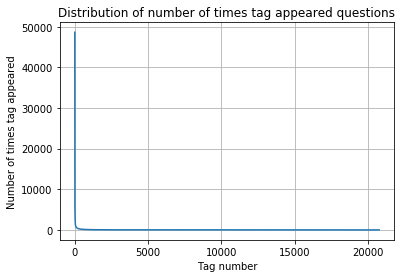

In [34]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

In [43]:
print("Total tags within 10000 at a gap of 25 units:"+str(len(tag_counts[0:10000:25]))+"\n\n", "freq of each tag:\n\n",tag_counts[0:10000:25])

Total tags within 10000 at a gap of 25 units:400

 freq of each tag:

 [48629  2121  1117   835   652   540   460   419   375   345   315   283
   267   248   226   211   199   188   180   170   161   154   148   140
   134   127   123   118   115   110   105   101    98    95    92    89
    87    83    81    79    78    75    72    70    68    65    64    62
    60    59    58    56    55    54    53    52    50    49    48    47
    47    46    45    44    43    43    42    41    41    40    40    39
    38    38    37    36    36    35    34    33    33    33    32    32
    31    31    30    30    29    29    28    28    28    27    27    27
    26    26    26    25    25    25    24    24    24    23    23    23
    23    22    22    22    21    21    21    21    21    20    20    20
    20    19    19    19    19    19    18    18    18    18    17    17
    17    17    17    17    16    16    16    16    16    16    16    15
    15    15    15    15    15    15    14    14    1

So Highest occuring tag is occuring 48629 times.The distribution is highly skewed referring most tags occurs less times only few popular tags occur more.

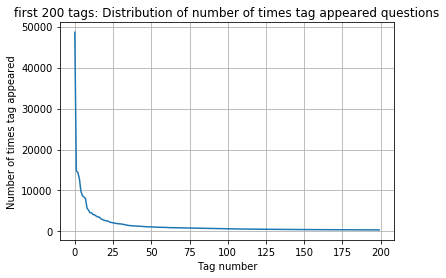

In [54]:
plt.plot(tag_counts[0:200])
plt.title('first 200 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()


In [69]:
tag_counts

array([48629, 14759, 14403, ...,     1,     1,     1], dtype=int64)

###### Quantile plot to show distribution in quantiles (100 tags)

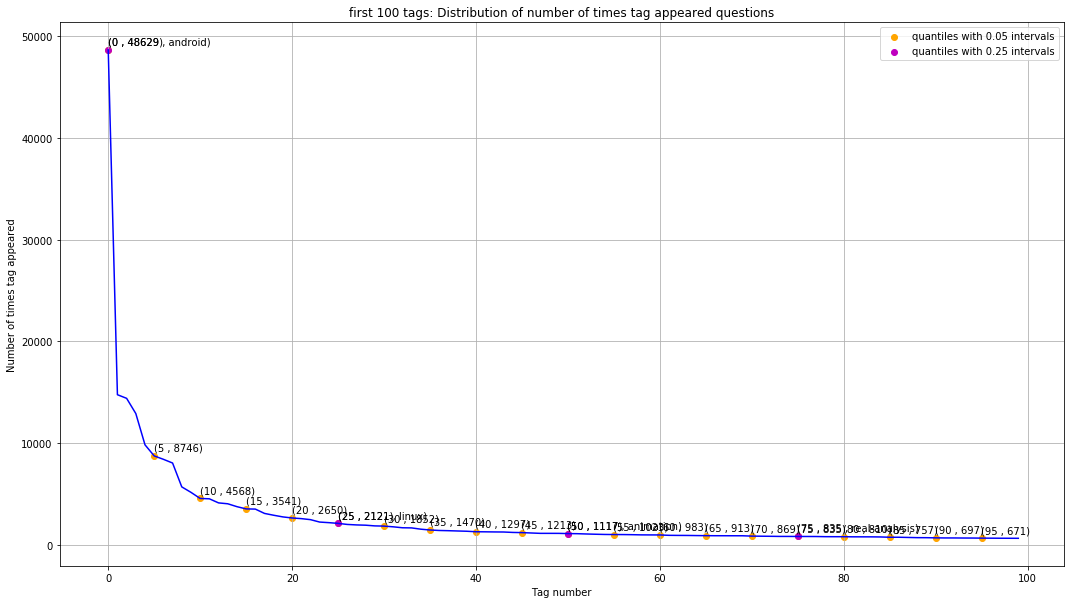

Total tags within 100 at a gap of 5:20

 freq of each tag:

 [48629  8746  4568  3541  2650  2121  1852  1470  1297  1213  1117  1023
   983   913   869   835   810   757   697   671]


In [89]:
plt.figure(figsize=(18,10))
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {} , {})".format(x,y,tag_names[x]), xy=(x,y), xytext=(x-0.05, y+500))
    
for x,y in zip(list(range(0,100,5)), tag_counts[0:100:5]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))
    
    
    

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print("Total tags within 100 at a gap of 5:"+str(len(tag_counts[0:100:5]))+"\n\n", "freq of each tag:\n\n",tag_counts[0:100:5])


The plot shows the tags that occur most lies within 1st 5% of data.  
Within 5% of tags is upto a freq of 8746  
Within 25% of tags is upto a freq of 2121  

In [95]:
# Store tags greater than 1000 in one list
lst_tags_gt_1k = tag_df[tag_df.Counts>1000].Tags
#Print the length of the list
print ('{} Tags are used more than 1000 times'.format(len(lst_tags_gt_1k)))
# Store tags greater than 100K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list.
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))

58 Tags are used more than 1000 times
4 Tags are used more than 10000 times


###### Bar plot to show frequencies

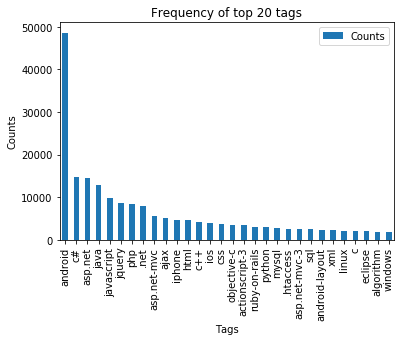

In [97]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

###### Observations (For 2M datapoints) 

1. There are total 58 tags which are used more than 1000 times.
2. 4 tags are used more than 10000 times.
3. Most frequent tag (i.e. android) is used 48629 times.
4. Least frequent tag (i.e. zywall) is used 1 time.
5. Around 5% of tags occur more frequently than others.And the distribution is highly skewed
6. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

### 3.Tags per question

In [103]:
#Storing the count of tag in each question in list 'tag_count'

#getting sum across rows to get sum of tags in each question or datapoint
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 200001 datapoints.
[2, 3, 4, 2, 2]


1st question has 2 tags

In [104]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.923435


###### no of Tags vs no of Questions

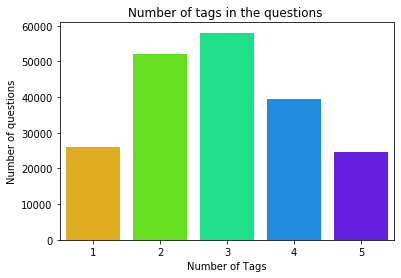

In [105]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Most of the questions have 3 tags.  
Very few questions have 1 or 5 tags

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.9
4. Most of the questions are having 2 or 3 tags

### 4.Most frequent tags

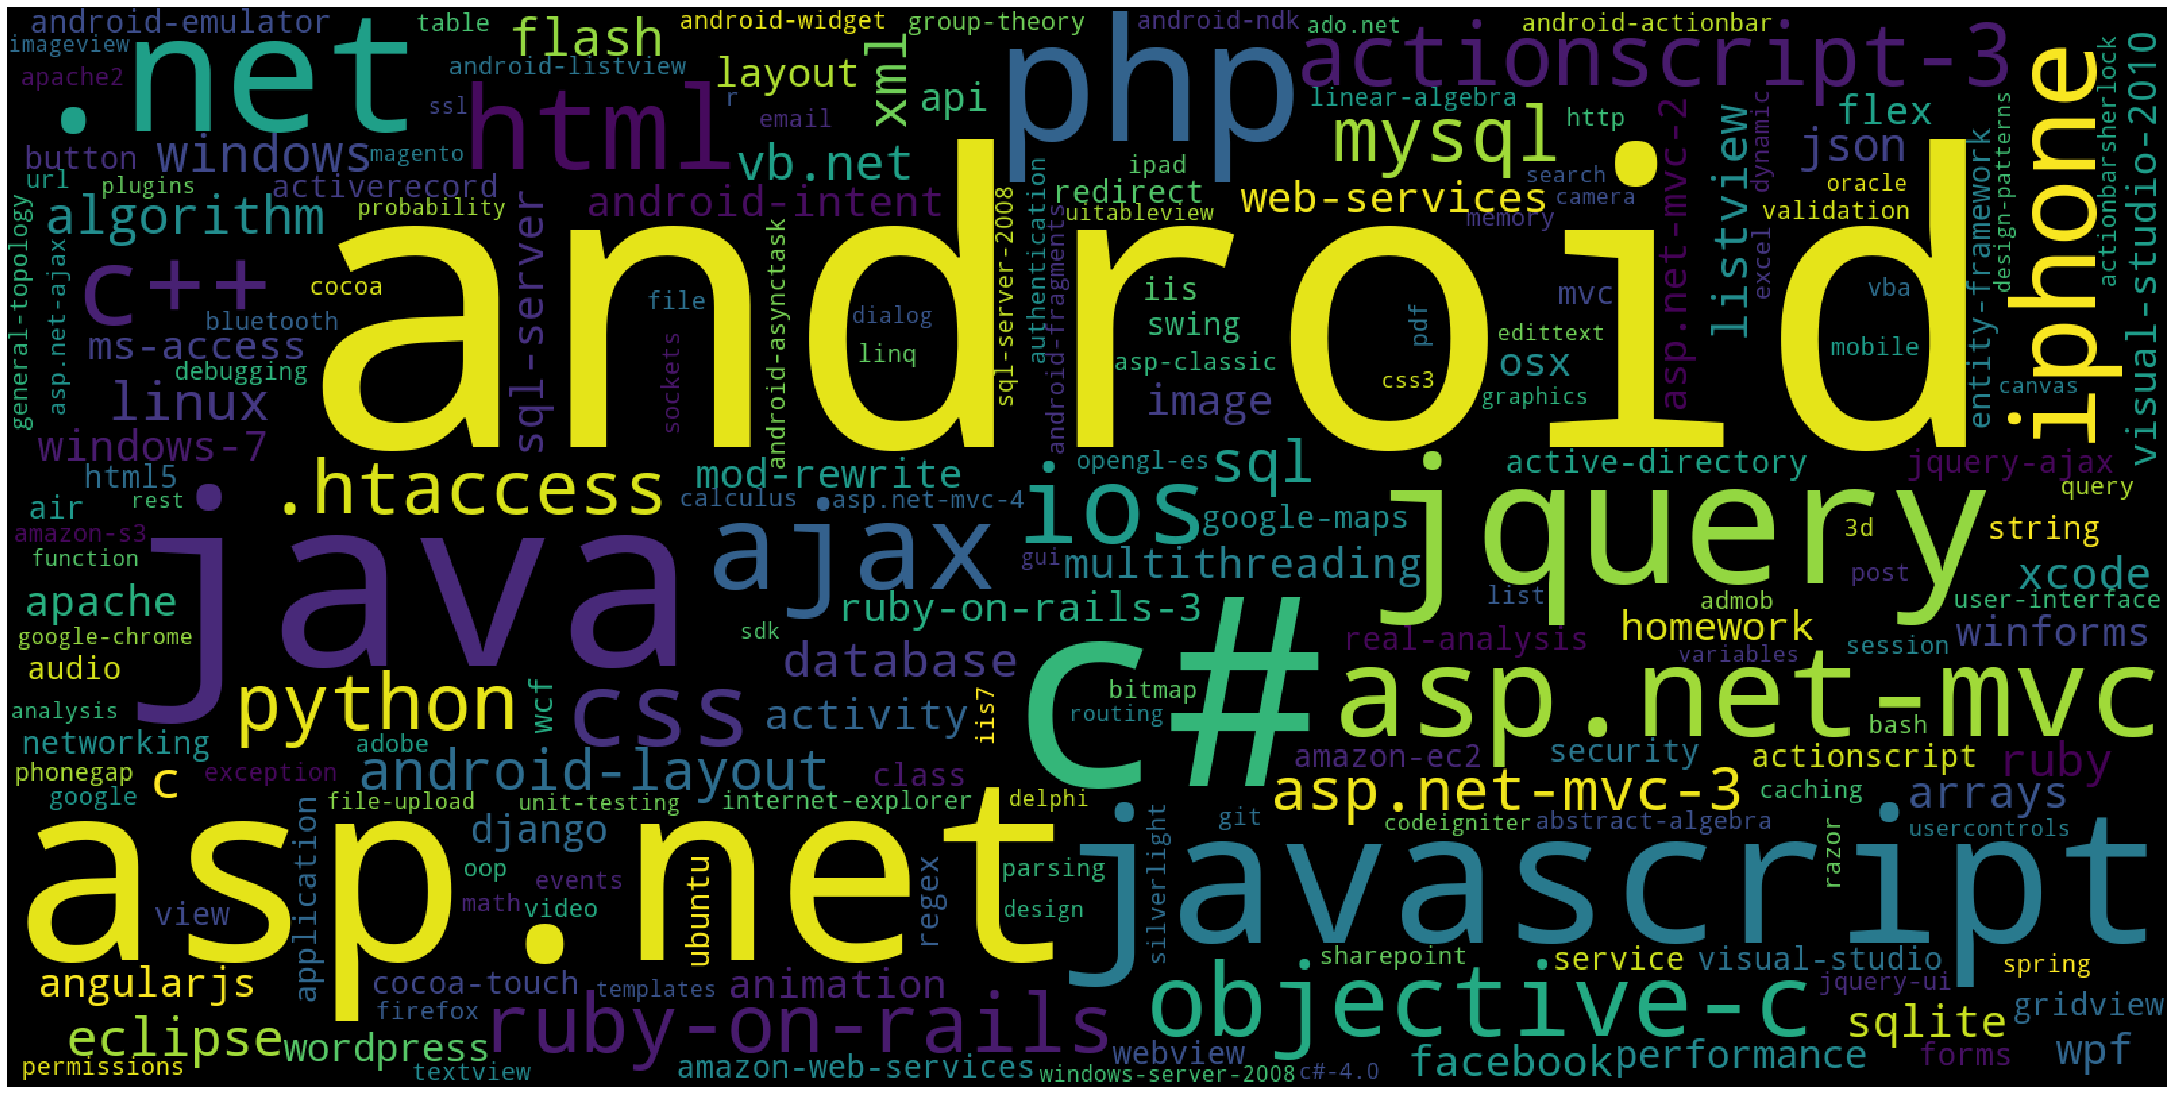

Time taken to run this cell : 0:00:06.067072


In [108]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

Most frequent tags ---> android,c#,asp.net,java  
Least frequent tags ---> firefox,table,ssl

## Cleaning and Preprocessing

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [3]:
#method to make db connection

#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [4]:

#Method to create a tbale in database

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [5]:
#Method to check if table exists

def checkTableExists(dbcon):
    
    
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    #the cursor object will search for any table type
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))


In [6]:
def create_database_table(database, query):
    
    #cll the method to create connection to database
    conn = create_connection(database)
    
    if conn is not None:
        
        #call the method to create a table in database
        create_table(conn, query)
        #call the method to check if table already exists
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

In [7]:
#sql uery to create the table with name QuestionsProcessed with columns--->question,code,tags,words_pre,words_post,is_code
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [8]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()

read_db = 'train_no_dup.db'


write_db = 'Processed.db'


#read points from train_no_dup.db
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        
        #select 1M points from no_dup_train database Randomly
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 50000;")

#write points into Processed.db
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:04:06.939064


### Data preprocessing

In [10]:
# to remove html tags like <br>

def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
#For stopwords
stop_words = set(stopwords.words('english'))
#For stemming
stemmer = SnowballStemmer("english")

In [12]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

from nltk.tokenize import word_tokenize


start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

#for each row or data point
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]
    
    

    #check if the body contains any code
    if '<code>' in question:
        #then increase the counter
        questions_with_code+=1
        #if code exists then put 1
        is_code = 1
    
    #get the length of question and title combined
    x = len(question)+len(title)
    
    #get the preprocessed length
    len_pre+=x

    
    #seperate the code body into code variable
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    #We are replacing all code present between "<code> and </code> " with " " and
    #re.MULTILINE makes replacement at each line and if any line contains multiple lines re.DOTALL treats them as a single line
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    
    #Characters can be encoded using differenct techniques such as unicode, ascii etc. So if the string that we obtained 
    #is in some other encoding and we want to convert it into unicode, then we use encode('utf-8')
    
    question=striphtml(question.encode('utf-8'))
    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    
    #It will remove all the numbers that are there
    question=re.sub(r'[^A-Za-z]+',' ',question)
    
    
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question except for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if     j not in stop_words    and    (len(j)!=1 or j=='c')    )

    
    #get the post processed length
    len_post+=len(question)
    
    
    #create a touple to fill all the columns of QuestionsProcessed table in Processed.db
    tup = (question,code,tags,x,len(question),is_code)
    
    #counter for no of questions processed
    questions_proccesed += 1
    
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    
    #check the progress after every 5000 questions.Total questions or points we took are 50000
    if (questions_proccesed%5000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 5000
number of questions completed= 10000
number of questions completed= 15000
number of questions completed= 20000
number of questions completed= 25000
number of questions completed= 30000
number of questions completed= 35000
Avg. length of questions(Title+Body) before processing: 1177
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57
Time taken to run this cell : 0:01:43.310038


In [13]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

### Reading Sample data from database

###### Read some question datapoints

In [17]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question  From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('possibl connect differ product object one contract problem ni want custom abl connect mani differ product one contract code list product attach contract feel dirti model list product connect contract code look someth like find sane way find kind product product current solut ni solv like whole mess feel wrong happi pointer right direct fetch specif product like pseudo ish code list real product baseproduct instanc need help nsugggest kind sane way ni mind abstract everyth away bunch step get cleaner code',)
----------------------------------------------------------------------------------------------------
('protect earli access build c applic want releas bunch tester lt need simpl way limit tester distribut need super duper hack proof protect imposs normal user circumv protect easili requir everi user run registr applic probabl even afford make one build per tester though rather like avoid would cool could add time limit limit circul definit enough open 

###### Read some tags datapoints

In [21]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT tags  From QuestionsProcessed LIMIT 10")
        print("tags after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

tags after preprocessed
('python django django-models application-design',)
----------------------------------------------------------------------------------------------------
('copy-protection',)
----------------------------------------------------------------------------------------------------
('homework linear-algebra vector-spaces determinant',)
----------------------------------------------------------------------------------------------------
('java maven-2 dependencies pom.xml',)
----------------------------------------------------------------------------------------------------
('redhat kickstart',)
----------------------------------------------------------------------------------------------------
('c# .net initialization automatic-properties object-initializers',)
----------------------------------------------------------------------------------------------------
('jmeter',)
----------------------------------------------------------------------------------------------------

###### Read length of question and title

In [41]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT words_pre, words_post From QuestionsProcessed LIMIT 10")
        print("Question + Title length before and after preprocessed")
        print('='*100)
        reader.fetchone()
        for pre,post in reader:
            print(str(pre)+" "+str(post))
            print('-'*100)
conn_r.commit()
conn_r.close()

Question + Title length before and after preprocessed
2441 509
----------------------------------------------------------------------------------------------------
832 488
----------------------------------------------------------------------------------------------------
1120 529
----------------------------------------------------------------------------------------------------
244 130
----------------------------------------------------------------------------------------------------
859 297
----------------------------------------------------------------------------------------------------
842 154
----------------------------------------------------------------------------------------------------
1118 516
----------------------------------------------------------------------------------------------------
3048 345
----------------------------------------------------------------------------------------------------
1593 1004
------------------------------------------------------------

##### Save database data into a panda dataframe

In [42]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question,code,tags,words_pre,words_post,is_code FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [43]:
preprocessed_data.head()

,question,code,tags,words_pre,words_post,is_code
0,max cliqu np problem question show recognit ve...,[],homework np-complete,286,119,0
1,possibl connect differ product object one cont...,['class Contract(models.Model):\n # The con...,python django django-models application-design,2441,509,1
2,protect earli access build c applic want relea...,[],copy-protection,832,488,0
3,use determin verifi linear independ span basi ...,[],homework linear-algebra vector-spaces determinant,1120,529,0
4,find pom depend classnam found depend classnam...,[],java maven-2 dependencies pom.xml,244,130,0


In [44]:
preprocessed_data = preprocessed_data[["question","tags"]]

In [45]:
preprocessed_data.head()

,question,tags
0,max cliqu np problem question show recognit ve...,homework np-complete
1,possibl connect differ product object one cont...,python django django-models application-design
2,protect earli access build c applic want relea...,copy-protection
3,use determin verifi linear independ span basi ...,homework linear-algebra vector-spaces determinant
4,find pom depend classnam found depend classnam...,java maven-2 dependencies pom.xml


In [46]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 49995
number of dimensions : 2


## Machine Learning Models

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>


In [88]:
len(preprocessed_data["tags"].unique())

38665

X --> question   
y---> tags  

We have to binarize the y into binary vectors where 1 represents presence of the tag and 0 represents absence.  
But we have 38665 tags which will lead to a vector of size 38665.So we need to sample the most frequent Tags that cover majority of data.It will reduce the Time complexity.


In [86]:
# binary='true' will give a binary vectorizer

# Binary vectorizing the class labels i.e the Tags
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [87]:
multilabel_y.todense().shape

(49995, 13898)

So total number of unique tags are 13898

In [56]:

# Function to return the binary matrix of 'n' no of most frequent tags. 
def tags_to_choose(n):
    
    #getting sum across columns to get the count of occurence each tag
    t = multilabel_y.sum(axis=0).tolist()[0]
    #sort based on occurence of count i.e descending order
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    #from the sparse matrix multilabel_y all the rows and only the columns i.e tags correponding to n number will be choosen
    #sorted_tags_i[:n] ---> it will choose the n most tags from the sorted list and will map it to columns of multilabel_y
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

#Function to return the no of questions in which "n" most frequent tags have occured
def questions_explained_fn(n):
    #get the sparse matrix
    multilabel_yn = tags_to_choose(n)
    #get the sum across rows i.e how many tags occured in each question
    x= multilabel_yn.sum(axis=1)
    #if count is 0 then no tags occured inthe question out of n tags and if non zero then out of n tags the question contains 
    #the tag i.e the question is not partially explained by the n tags
    return (np.count_nonzero(x==0))

In [116]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]

#iterate from 500 tags
for i in range(500, total_tags, 100):
    
    # it will give the total % of questions explained or has any of the 'n' no of tags
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

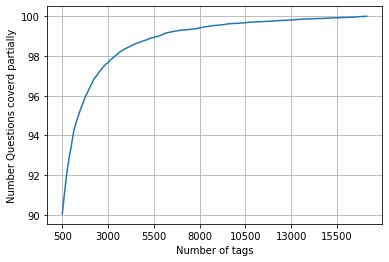

with  5500 tags we are covering  99.256 % of questions
with  500 tags we are covering  90.051 % of questions


In [63]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

###### We are taking 500 tags to build the model for ease of computation. 

In [71]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 4974 out of  49995


In [72]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 13898
number of tags taken : 500 ( 3.5976399481939847 %)


__ We consider top 3.5% tags which covers  90.051% of the questions __

In [74]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (39996, 500)
Number of data points in test data : (9999, 500)


<h2> Split the data into test and train (80:20) </h2>

In [67]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

<h2> Featurizing data </h2>

In [75]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3)) #taking bi and tri grams
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:24.586700


In [76]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (39996, 105663) Y : (39996, 500)
Dimensions of test data X: (9999, 105663) Y: (9999, 500)


<h3> Applying Logistic Regression with OneVsRest Classifier </h3>

In [83]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.21832183218321832
Hamming loss  0.0029334933493349335
Micro-average quality numbers
Precision: 0.6837, Recall: 0.3442, F1-measure: 0.4579
Macro-average quality numbers
Precision: 0.5154, Recall: 0.2485, F1-measure: 0.3167
              precision    recall  f1-score   support

           0       0.61      0.28      0.38       778
           1       0.82      0.57      0.67       714
           2       0.77      0.47      0.58       681
           3       0.71      0.42      0.52       627
           4       0.94      0.74      0.83       535
           5       0.86      0.68      0.76       512
           6       0.65      0.32      0.43       318
           7       0.86      0.56      0.68       291
           8       0.70      0.39      0.50       296
           9       0.85      0.64      0.73       314
          10       0.72      0.45      0.55       297
          11       0.40      0.18      0.25       273
          12       0.48      0.14      0.21       283
        

c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

The classification report gives precision and recall score for every tag.The recall scores are relatively less.We can try to improve the recall score.  

The most important metric is **F1micro = 0.45**. We can try to improve the score by doing hyperparameter tuning.

In [131]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_title_weight.pkl') 

c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['lr_with_equal_title_weight.pkl']

Since title mostly covers the idea of the whole question so we can give more weightage to title by just simply adding title 3times to the question column of our processed dataframe.

### Applying LR with more Title weight (3 times)

In [162]:
#sql uery to create the table with name QuestionsProcessed with columns--->question,code,tags,words_pre,words_post,is_code
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [163]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

start = datetime.now()

read_db = 'train_no_dup.db'


write_db = 'Titlemoreweight.db'


#read points from train_no_dup.db
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        
        #select 50000 points from no_dup_train database Randomly
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 50000;")

#write points into Processed.db
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:02:11.445926


In [164]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

from nltk.tokenize import word_tokenize


start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

#for each row or data point
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]
    
    

    #check if the body contains any code
    if '<code>' in question:
        #then increase the counter
        questions_with_code+=1
        #if code exists then put 1
        is_code = 1
    
    #get the length of question and title combined
    x = len(question)+len(title)
    
    #get the preprocessed length
    len_pre+=x

    
    #seperate the code body into code variable
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    #We are replacing all code present between "<code> and </code> " with " " and
    #re.MULTILINE makes replacement at each line and if any line contains multiple lines re.DOTALL treats them as a single line
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    
    #Characters can be encoded using differenct techniques such as unicode, ascii etc. So if the string that we obtained 
    #is in some other encoding and we want to convert it into unicode, then we use encode('utf-8')
    
    question=striphtml(question.encode('utf-8'))
    title=title.encode('utf-8')
    
    
    #Here we are upsampling the "title" by 3 times thus by giving 3times more weightage to it than the "question" 

    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
    #It will remove all the numbers that are there
    question=re.sub(r'[^A-Za-z]+',' ',question)
    
    
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question except for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if     j not in stop_words    and    (len(j)!=1 or j=='c')    )

    
    #get the post processed length
    len_post+=len(question)
    
    
    #create a touple to fill all the columns of QuestionsProcessed table in Processed.db
    tup = (question,code,tags,x,len(question),is_code)
    
    #counter for no of questions processed
    questions_proccesed += 1
    
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    
    #check the progress after every 5000 questions.Total questions or points we took are 50000
    if (questions_proccesed%5000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 5000
number of questions completed= 10000
number of questions completed= 15000
number of questions completed= 20000
number of questions completed= 25000
number of questions completed= 30000
number of questions completed= 35000
number of questions completed= 40000
number of questions completed= 45000
Avg. length of questions(Title+Body) before processing: 1174
Avg. length of questions(Title+Body) after processing: 397
Percent of questions containing code: 57
Time taken to run this cell : 0:02:04.560147


In [165]:
# dont forget to close the connections, or else you will end up with locks

conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [166]:
#Taking 1 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question,code,tags,words_pre,words_post,is_code FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [167]:
preprocessed_data.head()

,question,code,tags,words_pre,words_post,is_code
0,sort mysql search result relev sort mysql sear...,"['Acre Road, Kingston upon Thames, KT2 6EA\n\n...",mysql search order relevance,1417,450,1
1,imag load facebook opengraph imag load faceboo...,"['&lt;meta property=""og:title"" content=""По тро...",facebook opengraph,1033,182,1
2,time lag document write script tag script tag ...,"['&lt;script type=""text/javascript"" href=""http...",javascript iframe asynchronous document.write,3173,835,1
3,recommend extern email market servic recommend...,[],email spam external solution marketing,1026,591,0
4,jqueri ajax make https request jqueri ajax mak...,"['$(document).ready( function() {\n $(""#get...",jquery ajax https nginx,2282,600,1


In [168]:
preprocessed_data = preprocessed_data[["question","tags"]]

In [169]:
# binary='true' will give a binary vectorizer

# Binary vectorizing the class labels i.e the Tags
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [170]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]

#iterate from 500 tags
for i in range(500, total_tags, 100):
    
    # it will give the total % of questions explained or has any of the 'n' no of tags
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

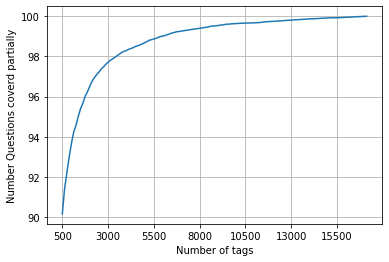

with  5500 tags we are covering  99.228 % of questions
with  500 tags we are covering  90.164 % of questions


In [171]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [184]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 4918 out of  49999


In [185]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 13894
number of tags taken : 500 ( 3.5986756873470562 %)


In [186]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (39999, 500)
Number of data points in test data : (9996, 500)


In [187]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [191]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3)) #taking bi and tri grams
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:26.402800


In [192]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (39999, 107652) Y : (39999, 500)
Dimensions of test data X: (10000, 107652) Y: (10000, 500)


In [193]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2226
Hamming loss  0.0028908
Micro-average quality numbers
Precision: 0.6953, Recall: 0.3601, F1-measure: 0.4744
Macro-average quality numbers
Precision: 0.5096, Recall: 0.2763, F1-measure: 0.3397
              precision    recall  f1-score   support

           0       0.60      0.28      0.38       770
           1       0.79      0.46      0.58       716
           2       0.85      0.54      0.66       681
           3       0.74      0.42      0.54       662
           4       0.92      0.73      0.81       575
           5       0.84      0.61      0.70       561
           6       0.61      0.34      0.44       361
           7       0.87      0.61      0.72       299
           8       0.69      0.45      0.54       277
           9       0.85      0.61      0.71       306
          10       0.85      0.42      0.56       317
          11       0.49      0.19      0.27       323
          12       0.56      0.13      0.21       233
          13       0.58      0.30

c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\akash\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

In [195]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l2'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1798
Hamming loss  0.0031
Micro-average quality numbers
Precision: 0.8119, Recall: 0.1881, F1-measure: 0.3055
Macro-average quality numbers
Precision: 0.2774, Recall: 0.0576, F1-measure: 0.0888
              precision    recall  f1-score   support

           0       0.66      0.14      0.23       770
           1       0.84      0.34      0.48       716
           2       0.88      0.46      0.61       681
           3       0.83      0.32      0.47       662
           4       0.95      0.61      0.74       575
           5       0.90      0.53      0.67       561
           6       0.62      0.17      0.27       361
           7       0.96      0.50      0.66       299
           8       0.80      0.29      0.42       277
           9       0.91      0.50      0.64       306
          10       0.91      0.31      0.46       317
          11       0.52      0.10      0.17       323
          12       0.82      0.06      0.11       233
          13       0.62      0.13   

In [ ]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

In [ ]:
#### Applying LR without SGD classifier.